# Data exploration

Lets take a look at the Melbourne pedestrian data and see what we think

In [40]:
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from IPython.core.display import Javascript
from IPython.display import HTML

import tqdm.notebook as tqdm

from ipyleaflet import Map, Marker,AwesomeIcon, Circle
import statsmodels.api as sm

from PedestrianDataImporter import getHourlyCounts
from MissingDataUtils import findMissingness, plotMissing
from DataFrameManipulations import countsLongToWideHourly
from Imputation import repairRepeatedMidnightStamps

In [2]:
# Also disable the scroll. I just don't like it
def disable_scroll():
    display(Javascript("""
        IPython.OutputArea.prototype._should_scroll = function(lines) {
            return false;
        }
    """))

disable_scroll()

<IPython.core.display.Javascript object>

In [3]:
df_counts,df_locations = getHourlyCounts['Melbourne']()
df_counts = repairRepeatedMidnightStamps(df_counts)
df_wide   = countsLongToWideHourly(df_counts)

Loading Melbourne_stored.pkl


In [4]:
df_counts

,ID,Location_ID,LocationName,HourlyCount,DateTime
0,2887628,34,Flinders St-Spark La,300,2019-11-01 17:00:00
1,2887629,39,Alfred Place,604,2019-11-01 17:00:00
2,2887630,37,Lygon St (East),216,2019-11-01 17:00:00
3,2887631,40,Lonsdale St-Spring St (West),627,2019-11-01 17:00:00
4,2887632,36,Queen St (West),774,2019-11-01 17:00:00
...,...,...,...,...,...
4562225,4567697,87,Errol St (West),185,2022-10-31 19:00:00
4562226,4567698,87,Errol St (West),108,2022-10-31 20:00:00
4562227,4567699,87,Errol St (West),58,2022-10-31 21:00:00
4562228,4567700,87,Errol St (West),18,2022-10-31 22:00:00


Closer inspection of the dataframes reveals that
* Not all the locations in the counts dataframe have locations in the locations dataframe.
* Not all the location in the locations dataframe have a record in the counts dataframe

In [5]:
l1 = df_counts['LocationName']
l2 = df_locations['Location_Desc']

print(f"{l1.nunique()} unique locations in count")
print(f"{l2.shape[0]} rows in location" )
print(f"{l2.nunique()} in counts")
print()

inBoth = list( set(l1).intersection(l2) )
justL1 = list( set(l1) - set(l2))
justL2 = list( set(l2) - set(l1))

print(f"{len(inBoth)} in both sets")
print(f"{len(justL1)} just in count data")
print(f"{len(justL2)} just in location data")

94 unique locations in count
113 rows in location
110 in counts

66 in both sets
28 just in count data
44 just in location data


What are the reasons for the duplicated location data?
* Birrarund Marr seems to have two sensors, one for pedestrians and one for bicycles
* Birrarung Marr East - Batman Ave Bridge Entry has two sensors in different directions.
* Harbour Esplanade just seems to be repeated twice.

In [6]:
duplicate_rows = df_locations[df_locations['Location_Desc'].duplicated(keep=False)]
duplicate_rows = duplicate_rows.sort_values('Location_Desc')
duplicate_rows

,Location_ID,Location_Desc,Sensor_Name,Installation_Date,Note,Location_Type,Status,Direction_1,Direction_2,Latitude,Longitude,Location
36,122,Birrarung Marr,FedCycle_T,2022-08-23,NaN,Outdoor,A,East,West,-37.818629,144.971694,"-37.81862929, 144.97169395"
42,7,Birrarung Marr,FedPed_T,2014-12-17,NaN,Outdoor,A,East,West,-37.818629,144.971694,"-37.81862929, 144.97169395"
37,124,Birrarung Marr East - Batman Ave Bridge Entry,BirBridge_T,2023-06-02,NaN,Outdoor,A,North,South,-37.817574,144.973299,"-37.81757416, 144.97329934"
81,123,Birrarung Marr East - Batman Ave Bridge Entry,BirBridge_T,2023-06-02,<Null>,Outdoor,A,East,West,-37.817537,144.973297,"-37.81753741, 144.97329734"
33,111,Harbour Esplanade,HarbBlix_T,2021-03-25,NaN,Outdoor Blix,A,NaN,NaN,-37.814426,144.944366,"-37.81442577, 144.94436558"
111,120,Harbour Esplanade,HarbBlix_T,2021-03-25,NaN,Outdoor Blix,A,NaN,NaN,-37.814426,144.944366,"-37.81442577, 144.94436558"


Only one site seems to seems to be counting bicycles

In [7]:
df_locations.loc[ df_locations['Sensor_Name'].str.contains('Cycle', case=False, na=False) ]

,Location_ID,Location_Desc,Sensor_Name,Installation_Date,Note,Location_Type,Status,Direction_1,Direction_2,Latitude,Longitude,Location
36,122,Birrarung Marr,FedCycle_T,2022-08-23,NaN,Outdoor,A,East,West,-37.818629,144.971694,"-37.81862929, 144.97169395"


## Site locations

First lets plot the sensor locations. Mouse of the icon to get the name of the sensor location

In [8]:
def showSensorLocations(df_locations,zoom=13):
    center = (df_locations['Latitude'].median(), df_locations['Longitude'].median())
    m = Map(center=center, zoom=zoom)
    icon=AwesomeIcon(name="map-pin", marker_color='red',icon_size=2)
    for index,row in df_locations.iterrows():
        marker = Marker(location=(row['Latitude'],row['Longitude']),
                        icon=icon,
                        draggable=False,opacity=1.0,
                        title=f"{row['Location_Desc']} - {row['Location_ID']}"
                        )
        m.add_layer(marker)
    display(m)
    
showSensorLocations(df_locations)

Map(center=[-37.81441438, 144.96510921], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

In [9]:
def showSensorLocations2(df_locations,zoom=13):
    center = (df_locations['Latitude'].median(), df_locations['Longitude'].median())
    m = Map(center=center, zoom=zoom)
    for index,row in df_locations.iterrows():
        circle = Circle()
        circle.location = (row['Latitude'],row['Longitude'])
        circle.radius = 20
        circle.color = "red"
        circle.fill_color = "red"
        m.add_layer(circle)
    display(m)
    
showSensorLocations2(df_locations)

Map(center=[-37.81441438, 144.96510921], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

## Inspecting missing data

  0%|          | 0/94 [00:00<?, ?it/s]

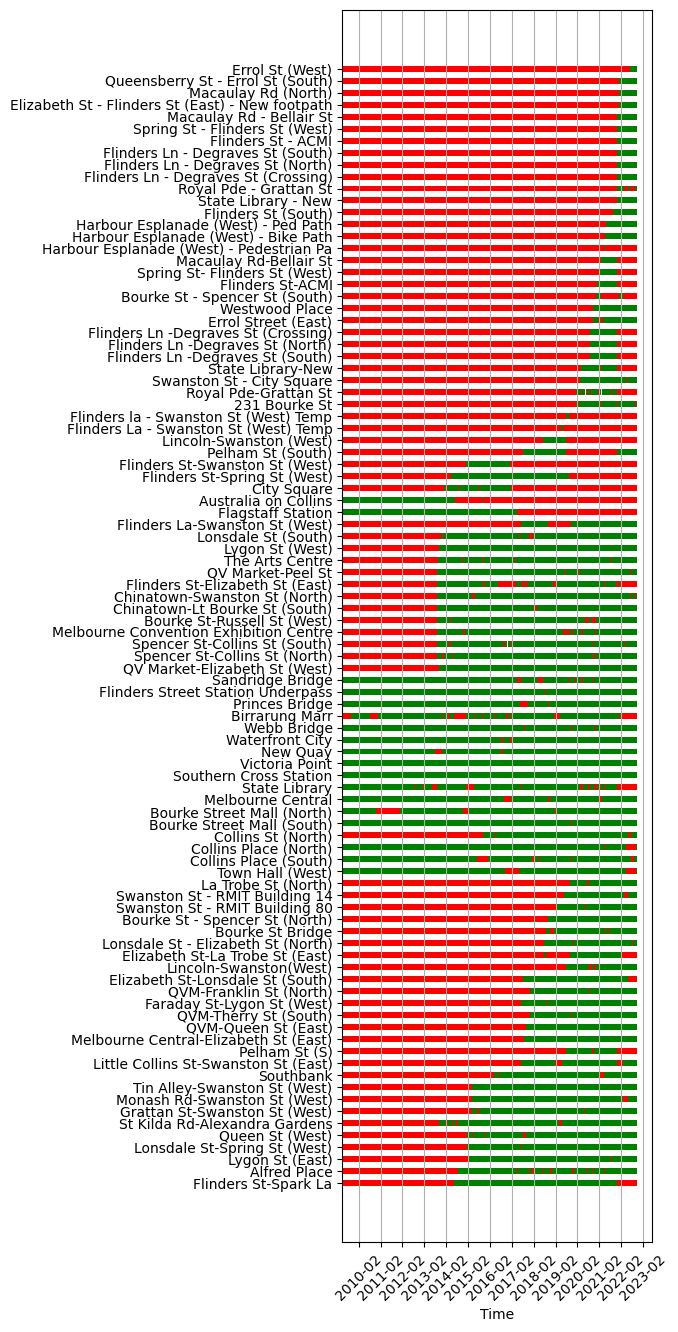

In [10]:
locations = df_counts['LocationName'].unique()
gaps_d = {location:findMissingness(df_wide,location) for location in tqdm.tqdm(locations)}
fig, ax = plt.subplots(figsize=(4,16))
plotMissing(gaps_d,ax)

## Inspection of the time series

Lets take a look at the sites which have complete data in 2018 and 2019

In [52]:
start_date = datetime.datetime(2018,1,1)
end_date   = datetime.datetime(2020,1,1)

cut = (df_wide.index >  start_date) & (df_wide.index < end_date ) 
df_cut = df_wide.loc[cut]
df_cut.dropna(axis='columns',how='any',inplace=True)
df_cut.index.freq = 'h'

C:\Users\jackl\AppData\Local\Temp\ipykernel_14412\1265319120.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut.dropna(axis='columns',how='any',inplace=True)


In [53]:
# Assuming df_cut is already defined and loaded with your data
# Resetting index to move datetime to a column
df_reset = df_cut.reset_index()

# Renaming the index column to 'datetime' if it's not already named
df_reset = df_reset.rename(columns={df_reset.columns[0]: 'datetime'})

# Melting the DataFrame to long-form
df_long = pd.melt(df_reset, id_vars='datetime', var_name='location', value_name='value')

df_long['year'] = df_long['datetime'].dt.year
df_long['week'] = df_long['datetime'].dt.isocalendar().week
df_long['year_week'] = df_long['year'].astype(str) + "-" + df_long['week'].astype(str).str.zfill(2)

# Normalizing datetime within each week
df_long['time_from_start_of_week'] = df_long['datetime'] - df_long['datetime'].dt.to_period('W').apply(lambda r: r.start_time)

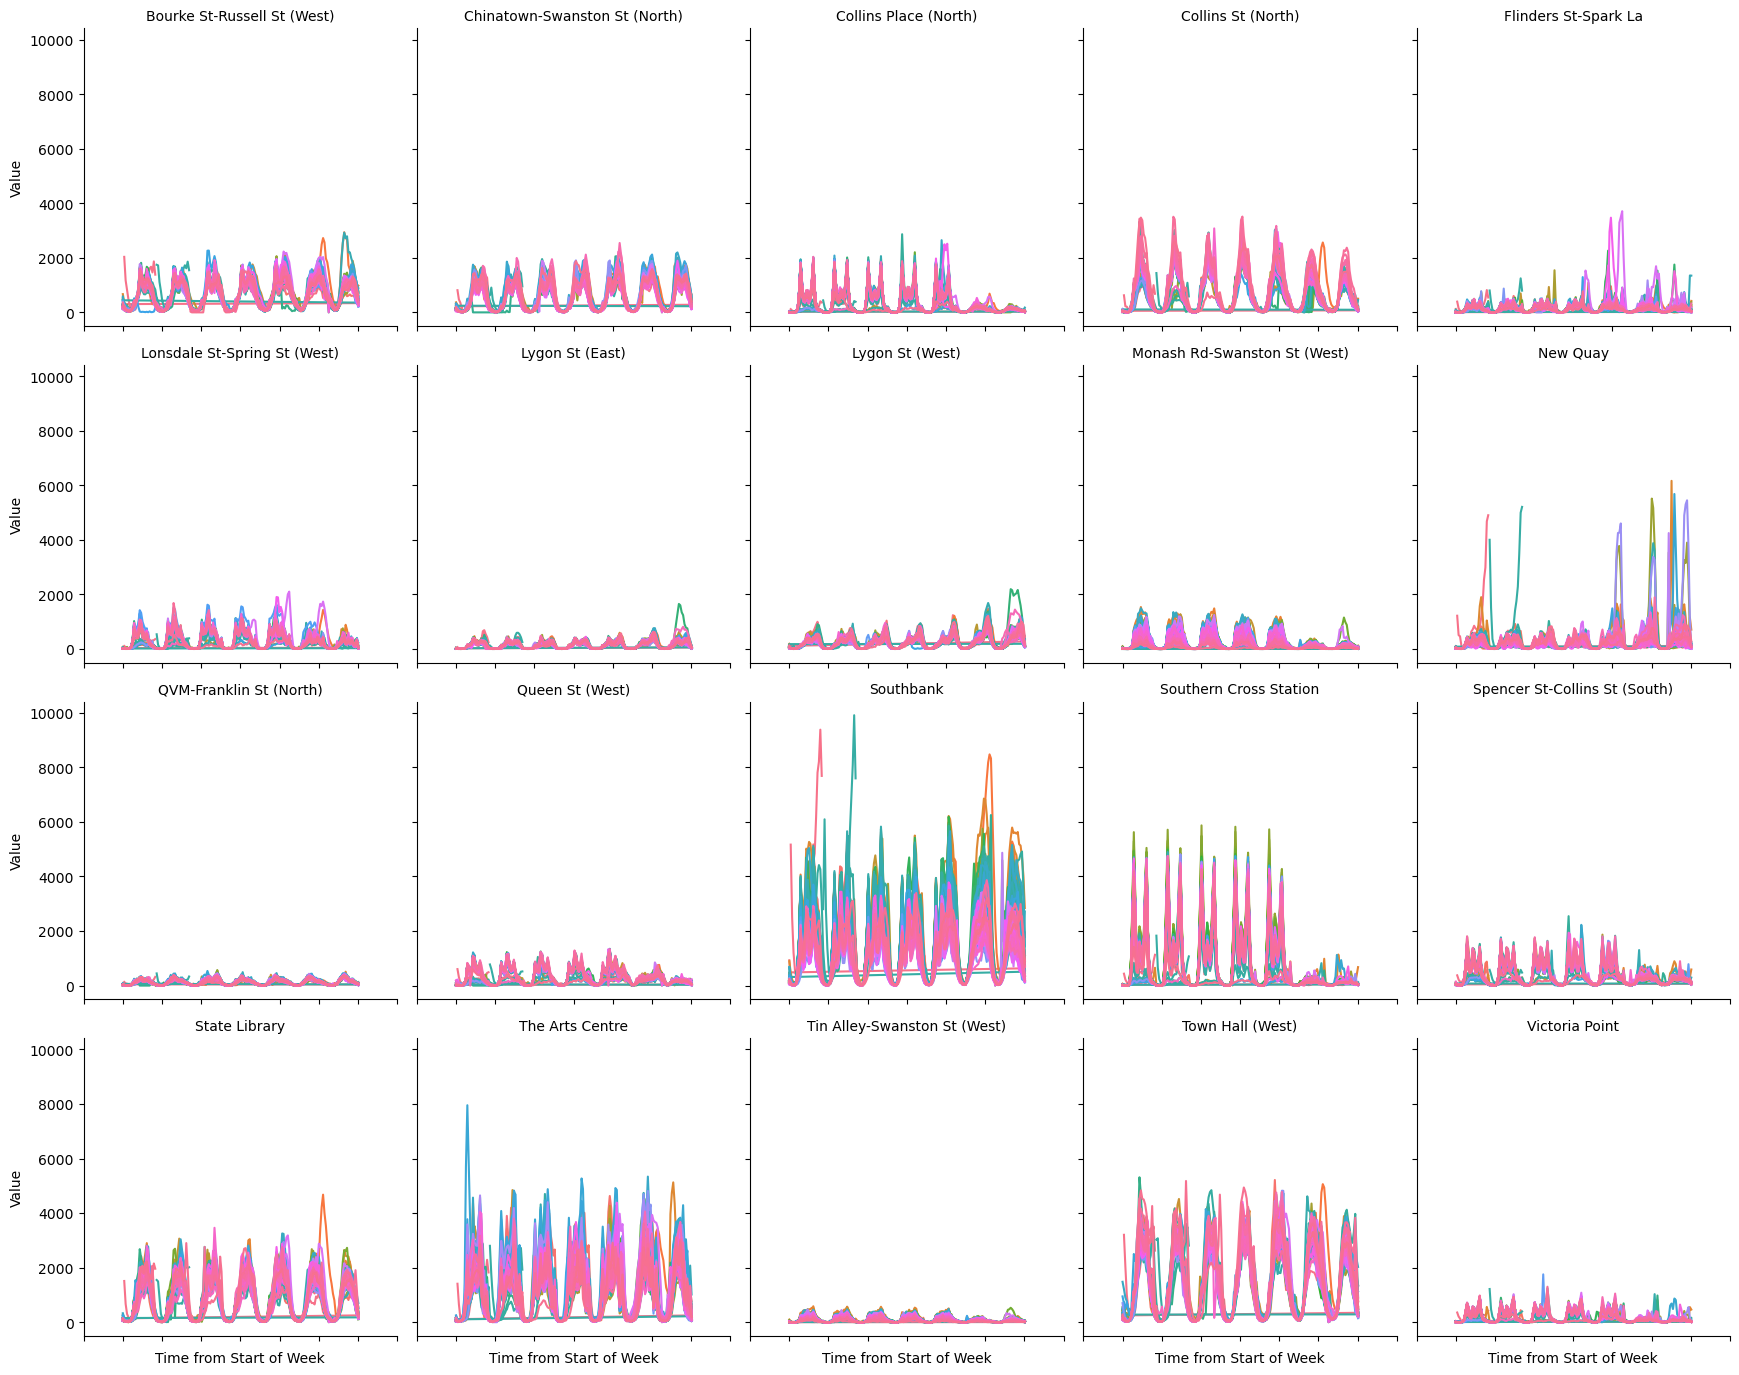

In [57]:
# Creating the FacetGrid
g = sns.FacetGrid(df_long, col="location", hue="year_week", col_wrap=5, height=3.5, palette="husl")
g = g.map(plt.plot, "time_from_start_of_week", "value")

# Adding labels, titles, and a legend
g.set_axis_labels("Time from Start of Week", "Value")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
#g.add_legend(title="Week")

#plt.show()
plt.savefig('WeeklyView.png', bbox_inches='tight')

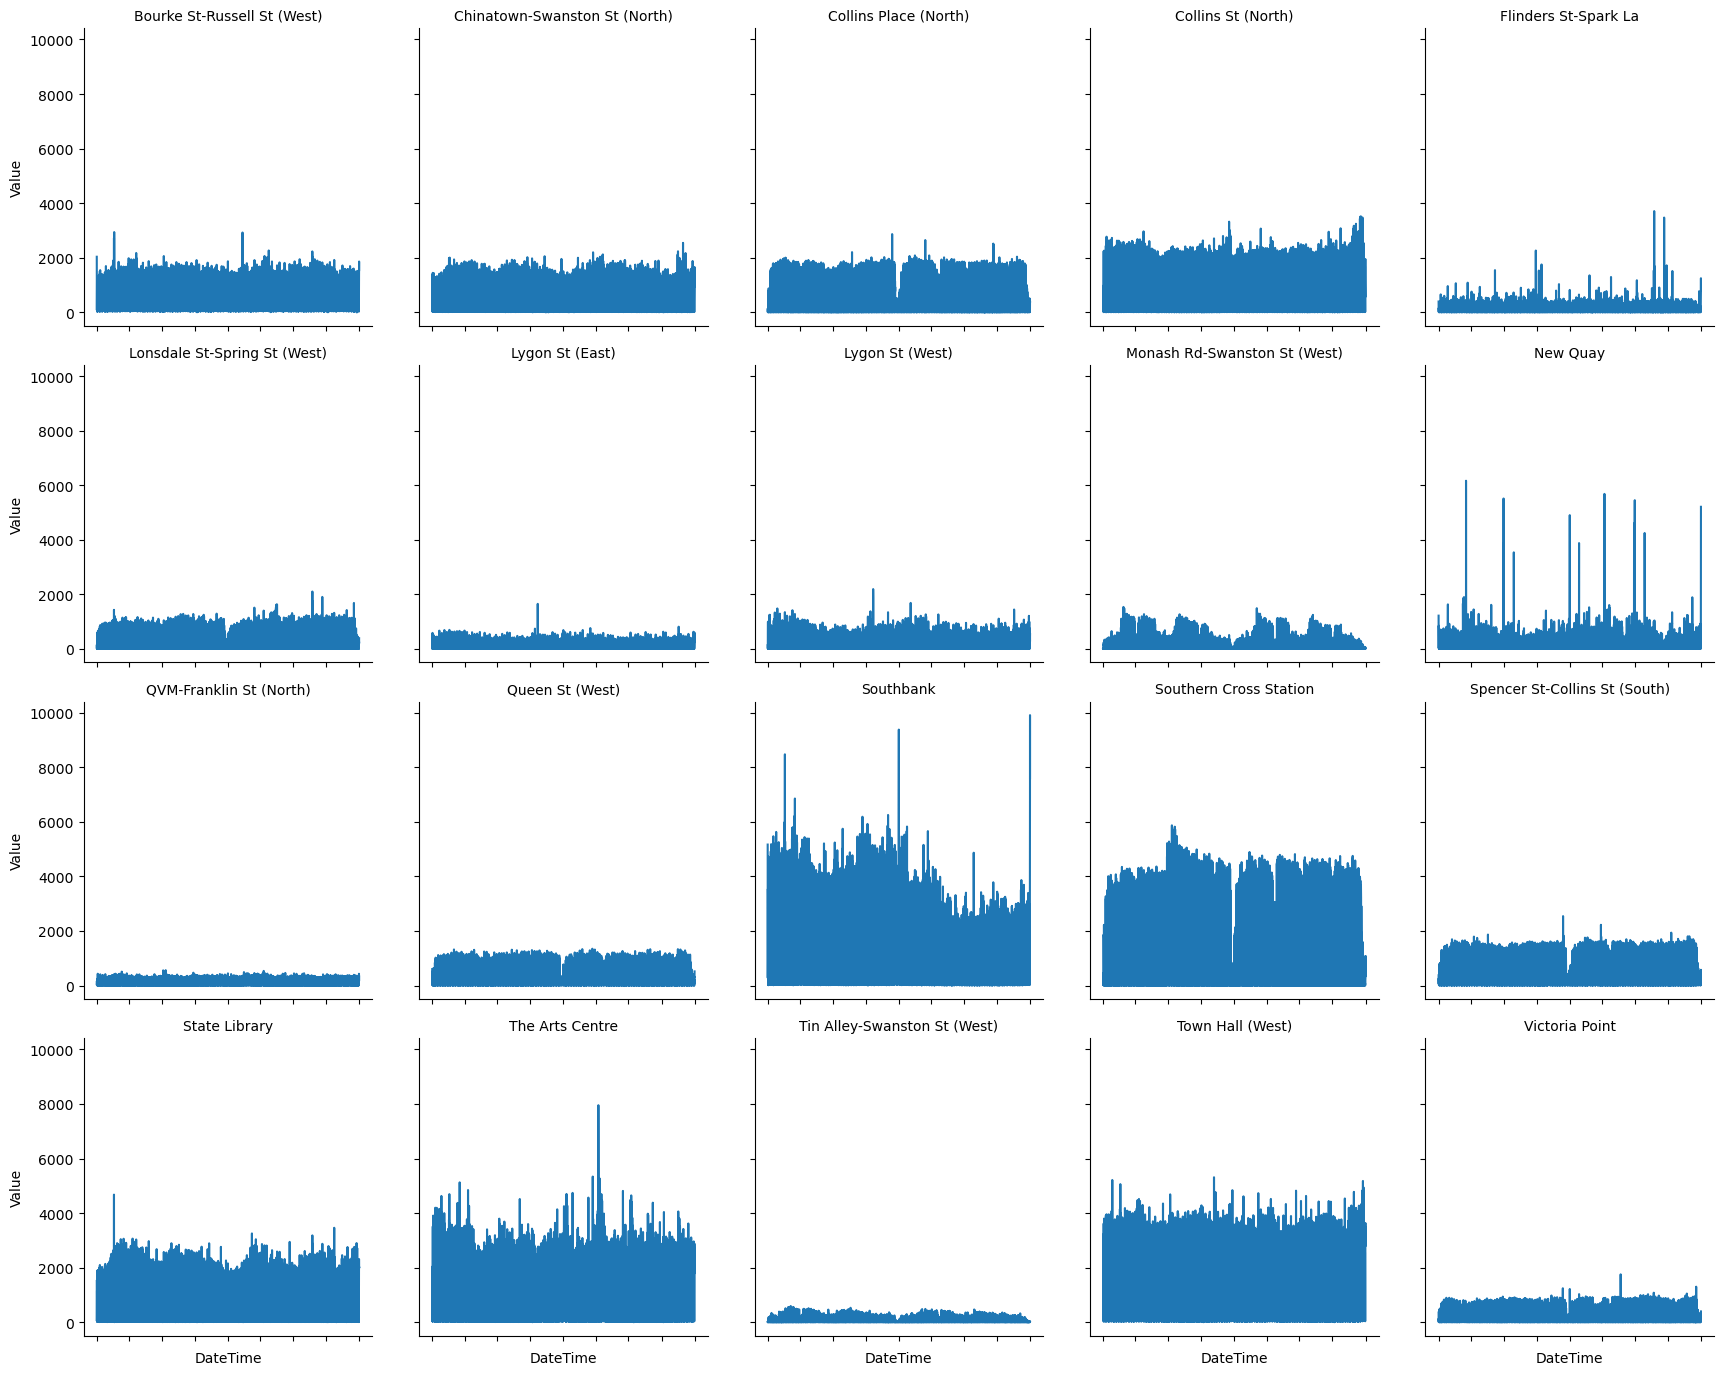

In [59]:
# Creating the FacetGrid
g = sns.FacetGrid(df_long, col="location", col_wrap=5, height=3.5)
g = g.map(plt.plot, "datetime", "value")

# Adding labels and titles
g.set_axis_labels("DateTime", "Value")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)

#plt.show()
plt.savefig('AnnualView.png', bbox_inches='tight')

## Decomposition

Lets look at some additive decompositions of the time series

In [24]:
decomps_naive7days = {col:sm.tsa.seasonal_decompose(
                                df_cut[col],
#                                 df1[col].head(24*7*30),
                                 model='additive',
                                 period=24*7,
                        ) for col in tqdm.tqdm(df_cut.columns)}
# %%

  0%|          | 0/20 [00:00<?, ?it/s]

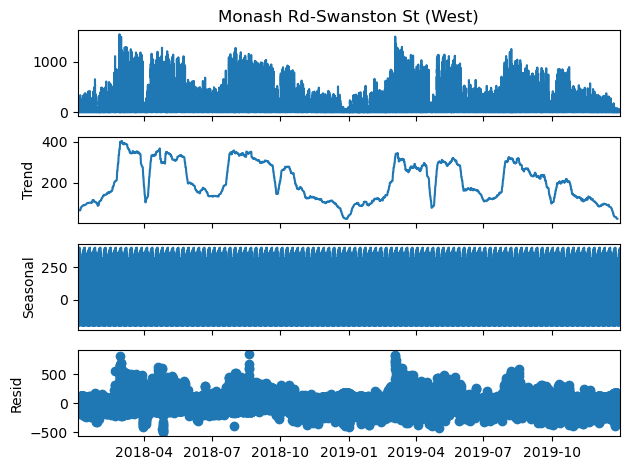

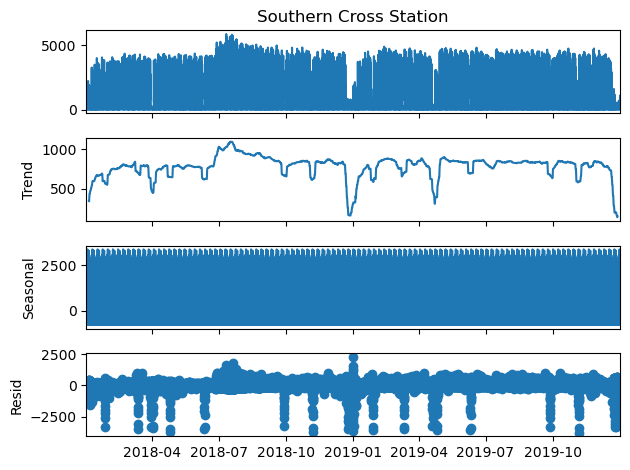

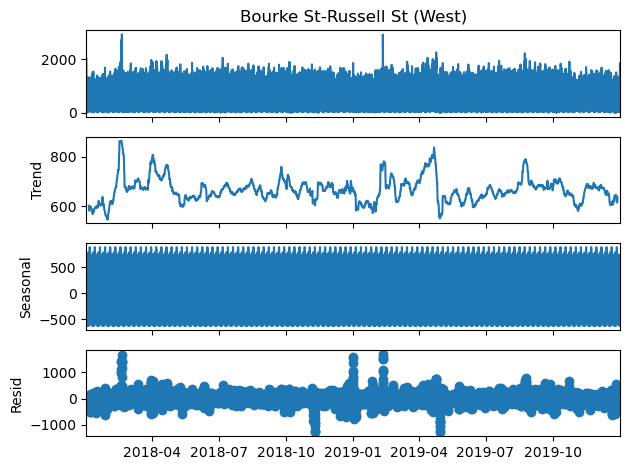

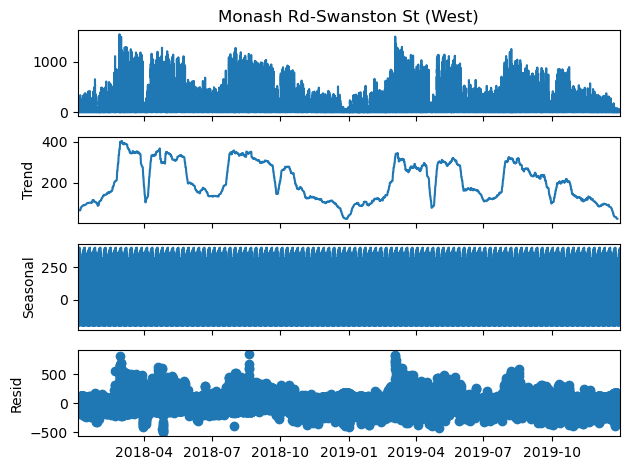

In [60]:
#fig,ax = plt.subplots(1,1)
decomps_naive7days['Southern Cross Station'].plot()
decomps_naive7days['Bourke St-Russell St (West)'].plot()
decomps_naive7days['Monash Rd-Swanston St (West)'].plot()

In [35]:
decomps_naive7days.keys()

dict_keys(['Bourke St-Russell St (West)', 'Chinatown-Swanston St (North)', 'Collins Place (North)', 'Collins St (North)', 'Flinders St-Spark La', 'Lonsdale St-Spring St (West)', 'Lygon St (East)', 'Lygon St (West)', 'Monash Rd-Swanston St (West)', 'New Quay', 'QVM-Franklin St (North)', 'Queen St (West)', 'Southbank', 'Southern Cross Station', 'Spencer St-Collins St (South)', 'State Library', 'The Arts Centre', 'Tin Alley-Swanston St (West)', 'Town Hall (West)', 'Victoria Point'])

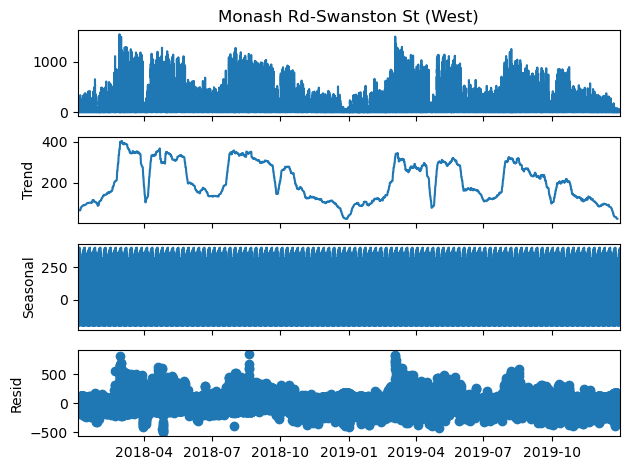

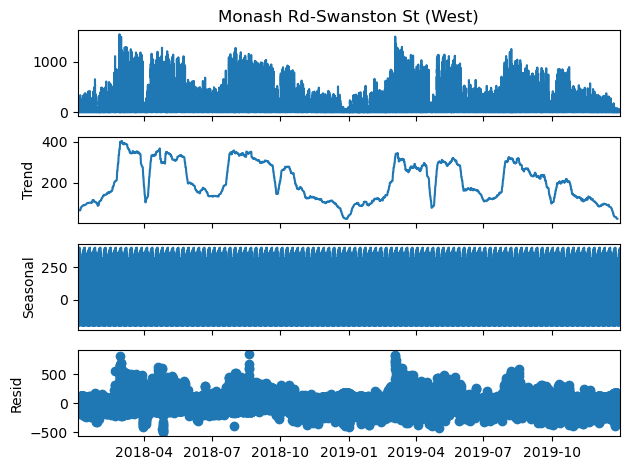

In [61]:
decomps_naive7days['Monash Rd-Swanston St (West)'].plot()